In [1]:
# setup and data ingestion

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Move to project root
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

sys.path.append('.')
from src.data_loader import WWTPDataLoader

# Load the data
loader = WWTPDataLoader(config_path="config/config.yaml")
df = loader.load_raw_data()

# Drop rows with missing values for the model
df_clean = df.dropna().copy()
print(f"Data ready for Modeling. Shape: {df_clean.shape}")

2026-02-17 21:58:19,299 - INFO - Configuration loaded successfully from config\config.yaml
2026-02-17 21:58:19,299 - INFO - Loading raw dataset from data\raw\Data-Melbourne_F_fixed.csv...
2026-02-17 21:58:19,307 - INFO - Dropped 'Unnamed: 0' artifact column.
2026-02-17 21:58:19,307 - INFO - Combining ['Year', 'Month', 'Day'] into datetime index...
2026-02-17 21:58:19,307 - INFO - Time-series index set successfully.


Data ready for Modeling. Shape: (1382, 16)


In [2]:
# Unsupervised Anomaly Detection

# 1. Isolate and scale the numeric sensors
sensor_cols = df_clean.select_dtypes(include='number').columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean[sensor_cols])

# 2. Pull hyperparameters dynamically from your config.yaml
model_params = loader.config['model']['isolation_forest']
contamination = model_params.get('contamination', 0.05)
random_state = model_params.get('random_state', 42)

print(f"Training Isolation Forest (Contamination: {contamination}, Random State: {random_state})...")

# 3. Initialize and fit the model
iso_forest = IsolationForest(
    contamination=contamination, 
    random_state=random_state,
    n_jobs=-1 # Uses all available CPU cores for speed
)

# 4. Predict the anomalies
# The model returns 1 for normal operation, and -1 for an anomaly
df_clean['Anomaly_Label'] = iso_forest.fit_predict(scaled_data)

# Calculate how many anomalies were found
total_days = len(df_clean)
anomalies_found = len(df_clean[df_clean['Anomaly_Label'] == -1])

print(f"Model Training Complete!")
print(f"Total Operational Days Evaluated: {total_days}")
print(f"Total Anomalous Days Detected: {anomalies_found} ({(anomalies_found/total_days)*100:.1f}%)")

Training Isolation Forest (Contamination: 0.05, Random State: 42)...
Model Training Complete!
Total Operational Days Evaluated: 1382
Total Anomalous Days Detected: 70 (5.1%)


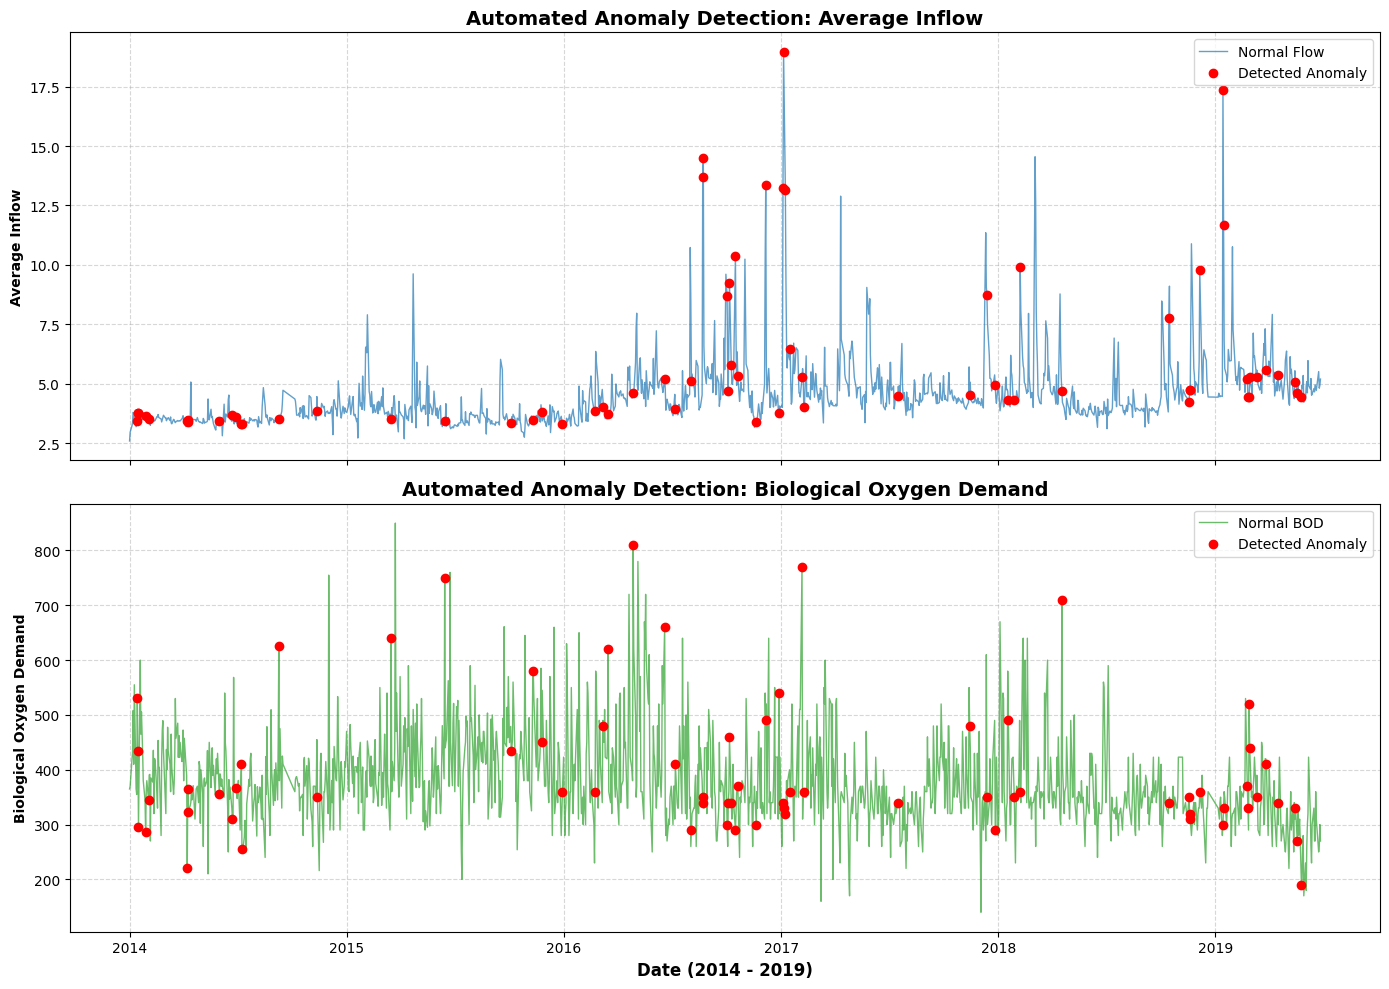

In [3]:
# Visualizing the Results

# Choose two features to visualize the anomalies against
feature_1 = 'Average Inflow'
feature_2 = 'Biological Oxygen Demand'

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# Separate normal data and anomaly data for plotting
normal_data = df_clean[df_clean['Anomaly_Label'] == 1]
anomaly_data = df_clean[df_clean['Anomaly_Label'] == -1]

# Plot 1: Average Inflow
axes[0].plot(df_clean.index, df_clean[feature_1], color='#1f77b4', linewidth=1, label='Normal Flow', alpha=0.7)
axes[0].scatter(anomaly_data.index, anomaly_data[feature_1], color='red', label='Detected Anomaly', zorder=5)
axes[0].set_ylabel(feature_1, fontweight='bold')
axes[0].set_title(f"Automated Anomaly Detection: {feature_1}", fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot 2: Biological Oxygen Demand
axes[1].plot(df_clean.index, df_clean[feature_2], color='#2ca02c', linewidth=1, label='Normal BOD', alpha=0.7)
axes[1].scatter(anomaly_data.index, anomaly_data[feature_2], color='red', label='Detected Anomaly', zorder=5)
axes[1].set_ylabel(feature_2, fontweight='bold')
axes[1].set_title(f"Automated Anomaly Detection: {feature_2}", fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.xlabel('Date (2014 - 2019)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [4]:
# Nailing the Hydraulic Shocks
# Look at the average inflow plot
# the isolation forest absolutely nailed those massive, violent spikes in late
# 2016 and late 2018. Without ever being explicityly told what a "storm" or a
# a "shock load" looks like, the math identified that those moments broke the
# physical rules of the plant's normal operating baseline.

In [5]:
# the isolation forest is looking at all 16 sensors at once.
# a day might have a totally normal BOD, but if the temperature suddenly dropped 
# 15 degrees and energy consumption inexplicably flatlined at the exact same time, the 
# model flags it as an anomaly. 